In [1]:
# LearningRate
LEARNINGRATE = 0.001

# Ephoch range
EPOCH_RANGE_LOWER = 0
EPOCH_RANGE_UPPER = 171

# manual seed
MANUALSEED = 2

# Hidden channels = amount of neurons in a layer
HIDDENCHANNELS = 64

# training data split (original 150)
DATASPLIT = 124 #split at 66/33 training to test data

In [2]:
# General imports
import os

# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp

# Graph imports
import torch
from torch import Tensor

import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx

#my imports
import torch.nn as nn
from torch_geometric.datasets import TUDataset

import networkx as nx
from networkx.algorithms import community

from tqdm.auto import trange

C:\Users\karen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#external helper package
%run visualize.py
from visualize import GraphVisualization 

In [4]:
# for downloading the dataset -- commented out because it's on my pc now -- uncomment below to install

dataset = TUDataset(root='dataset/MUTAGdata', name='MUTAG')
# dataset.download()

In [5]:
data_details = {
    "num_node_features": dataset.num_node_features,
    "num_edge_features": dataset.num_edge_features,
    "num_classes": dataset.num_classes,
    "num_node_labels": dataset.num_node_labels,
    "num_edge_labels": dataset.num_edge_labels
}

print(data_details)

{'num_node_features': 7, 'num_edge_features': 4, 'num_classes': 2, 'num_node_labels': 7, 'num_edge_labels': 4}


In [6]:
def create_graph(graph):
    g = to_networkx(graph)
    pos = nx.spring_layout(g)
    vis = GraphVisualization(
        g, pos, node_text_position='top left', node_size=20,
    )
    fig = vis.create_figure()
    return fig

fig = create_graph(dataset[8])
fig.show()

In [7]:
torch.manual_seed(MANUALSEED)
dataset = dataset.shuffle()

train_dataset = dataset[:DATASPLIT]
test_dataset = dataset[DATASPLIT:]


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 124
Number of test graphs: 64


In [8]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2634], x=[1191, 7], edge_attr=[2634, 4], y=[64], batch=[1191], ptr=[65])

Step 2:
Number of graphs in the current batch: 60
DataBatch(edge_index=[2, 2264], x=[1028, 7], edge_attr=[2264, 4], y=[60], batch=[1028], ptr=[61])



In [9]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(MANUALSEED)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        self.conv4 = GCNConv(hidden_channels, hidden_channels) #new
        self.conv5 = GCNConv(hidden_channels, hidden_channels) #new

        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.sign()
        x = self.conv2(x, edge_index)
        x = x.sign()
        x = self.conv3(x, edge_index)

        #new
        x = x.sign()
        x = self.conv4(x, edge_index)

        #new
        x = x.sign()
        x = self.conv5(x, edge_index)

        # 2. Readout layer
        x = global_max_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=HIDDENCHANNELS)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (conv5): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [10]:
model = GCN(hidden_channels=HIDDENCHANNELS)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE)
criterion = torch.nn.CrossEntropyLoss()

accuracies, loses = [], [] #define loses array


def train(t):
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         
         cat = torch.argmax(out, dim=1) #cat = catigorical accuracy
         accuracy = (data.y == cat).float().mean() # calculates accuray
         accuracies.append(accuracy)
         
         loss = criterion(out, data.y)  # Compute the loss.
         loses.append(loss.item()) #appends each new loss to the loses array
         

         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

         t.set_description("loss %.2f. accuracy %.2f." % (loss, accuracy)) 

In [11]:
for epoch in (t := trange(EPOCH_RANGE_LOWER, EPOCH_RANGE_UPPER)):
    train(t)
    

loss 0.17. accuracy 0.97.: 100%|██████████| 171/171 [00:05<00:00, 28.89it/s]


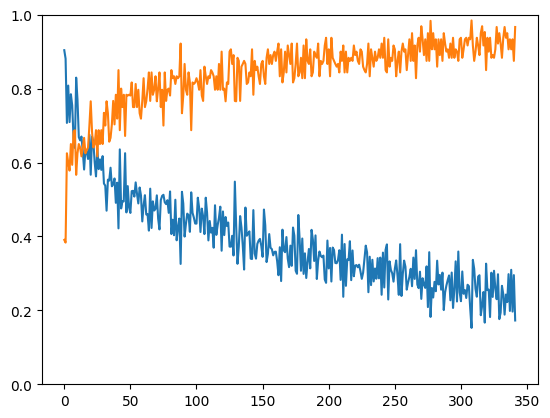

In [12]:
import matplotlib.pyplot as plt
plt.ylim(0, 1)
plt.plot(loses)
plt.plot(accuracies)


# is there a way to plot the amount of carcinogetic and non carcinogetic molecules? (in regards to what was discussed in MI L8 Slide 39)
    # i.e. that the accuracy doesn't tell the full story, Model B classified everything as "yes")